In [29]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from joblib import Parallel, delayed
from tqdm import tqdm
import time
import hicstraw

## Data directories

In [31]:
cell_type = 'old_fibroblasts'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

In [47]:
hic_data_dir = '/home/braunger/masterthesis/data/hic_data/old_fibroblasts/'
processed_hic_PCs_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_old_fibroblasts/intrachromosomal_PCs/'
save_dir = '/home/braunger/masterthesis/save/figures/get_PCs_'+cell_type+'/'

# For one chromosome

## Load observed/expected intrachromosomal hic data with straw

In [32]:
hic = hicstraw.HiCFile(hic_data_dir+'ENCFF768UBD_hg19.hic')
print(hic.getGenomeID())
print(hic.getResolutions())
hic

hg19
[2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000]


In [33]:
# Test how to get chromosome sizes
for chrom in hic.getChromosomes():
  print(chrom.name, chrom.length)

hic.getChromosomes()[2].length

ALL 3095693
1 249250621
2 243199373
3 198022430
4 191154276
5 180915260
6 171115067
7 159138663
8 146364022
9 141213431
10 135534747
11 135006516
12 133851895
13 115169878
14 107349540
15 102531392
16 90354753
17 81195210
18 78077248
19 59128983
20 63025520
21 48129895
22 51304566
X 155270560
Y 59373566
MT 16569


243199373

In [34]:
chrom = 1
matrix_object = hic.getMatrixZoomData(str(chrom), str(chrom), "oe", "NONE", "BP", resol)
numpy_matrix = matrix_object.getRecordsAsMatrix(0, hic.getChromosomes()[chrom].length, 0, hic.getChromosomes()[chrom].length)
numpy_matrix

array([[5.98767772e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.85771538e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.87881077e-03, ...,
        0.00000000e+00, 4.56216261e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.20797646e-01, 4.54149604e-01, 0.00000000e+00],
       [5.85771538e-02, 0.00000000e+00, 4.56216261e-02, ...,
        4.54149604e-01, 6.76689208e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [35]:
names = np.arange(0, hic.getChromosomes()[chrom].length, resol)
hic_intra = pd.DataFrame(numpy_matrix)
hic_intra.index = names
hic_intra.columns = names
hic_intra

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,247000000,247250000,247500000,247750000,248000000,248250000,248500000,248750000,249000000,249250000
0,0.000599,0.0,0.000000,0.000000,0.000000,0.000503,0.000000,0.000000,0.000000,0.000000,...,0.020955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058577,0.0
250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
500000,0.000000,0.0,0.005879,0.033811,0.018674,0.021468,0.018282,0.014573,0.012221,0.010331,...,0.041909,0.020798,0.020955,0.020955,0.027403,0.000000,0.000000,0.000000,0.045622,0.0
750000,0.000000,0.0,0.033811,0.780467,0.891722,0.804421,0.365479,0.329070,0.272862,0.248283,...,0.712457,0.377183,0.374367,0.167637,0.377183,0.274034,0.082210,0.136535,1.126417,0.0
1000000,0.000000,0.0,0.018674,0.891722,1.005113,0.745232,0.334357,0.300039,0.229454,0.195978,...,0.643948,0.356228,0.314319,0.228780,0.251455,0.104773,0.164421,0.219227,0.921614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248250000,0.000000,0.0,0.000000,0.274034,0.104773,0.125728,0.166386,0.377183,0.419092,0.751273,...,0.902003,0.965944,1.179724,1.064566,0.763123,0.775949,0.521480,0.492440,0.576024,0.0
248500000,0.000000,0.0,0.000000,0.082210,0.164421,0.041909,0.083818,0.228780,0.209546,0.251455,...,0.567963,0.642708,0.770442,0.744408,0.541378,0.521480,0.377931,0.266984,0.327435,0.0
248750000,0.000000,0.0,0.000000,0.136535,0.219227,0.137017,0.062864,0.230501,0.270376,0.335274,...,0.528466,0.665732,0.817079,0.756264,0.535415,0.492440,0.266984,0.420798,0.454150,0.0
249000000,0.058577,0.0,0.045622,1.126417,0.921614,0.575472,0.767296,1.005821,1.341095,1.830241,...,1.289608,1.433612,1.222117,0.793461,0.599564,0.576024,0.327435,0.454150,0.676689,0.0


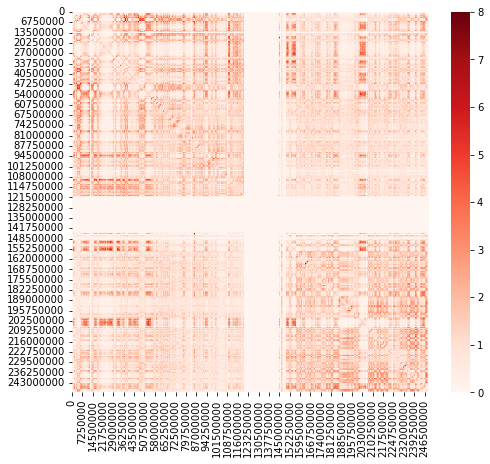

In [53]:
plt.figure(figsize = (8,7))
sns.heatmap(hic_intra, cmap = "Reds", vmax = 8)
plt.savefig(save_dir+"observed_expected_chrom_"+str(chrom)+".png")
plt.show()

### Create Correlation Matrix

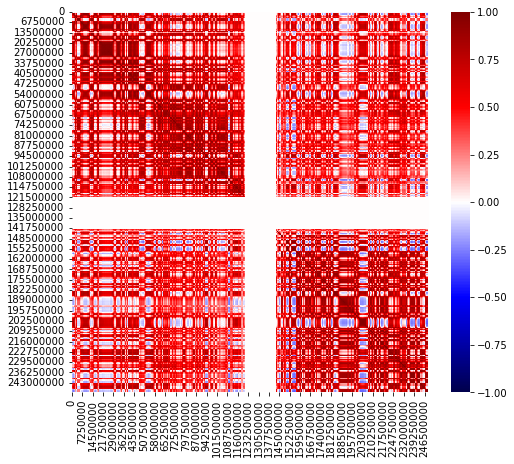

In [54]:
corr = hic_intra.corr()
corr = pd.DataFrame(np.nan_to_num(corr))
corr.index = hic_intra.index
corr.columns = hic_intra.columns

plt.figure(figsize = (8,7))
sns.heatmap(corr, cmap = "seismic", vmin = -1, vmax = 1)
plt.savefig(save_dir+"correlation_matrix_chrom_"+str(chrom)+".png")
plt.show()


### PCA on intrachromosomal data

In [24]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(hic_intra)
#PCs = np.nan_to_num(PCs)
PCs = pd.DataFrame({'PC1': PCs[:,0], 
                    'PC2': PCs[:,1]})
PCs.head()

,PC1,PC2
0,-29.398883,-11.683394
1,-29.548611,-11.710669
2,-28.207200,-11.829982
3,3.381073,-16.831190
4,5.744473,-18.448571


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

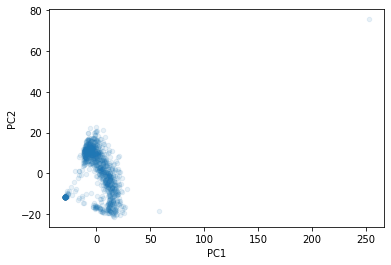

In [25]:
# Plot PC1 and PC2
%matplotlib inline
PCs.plot.scatter(x='PC1', y='PC2', alpha=0.1)

In [26]:
#Normalize PCs to use as features
# find mean and standard dev
mean = np.mean(PCs, axis=0)
std = np.std(PCs, axis=0)
PCs_norm = (PCs - mean)/std

### PCA on correlation matrix

In [27]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(corr)
PCs = pd.DataFrame({'PC1': PCs[:,0], 
                    'PC2': PCs[:,1]})
PCs.head()

,PC1,PC2
0,-0.317435,2.528122
1,1.246968,11.625084
2,-7.027347,4.030898
3,-9.788161,2.289375
4,-10.114415,2.962476


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

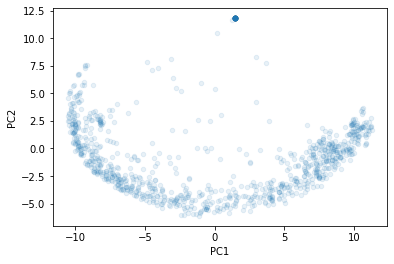

In [28]:
# Plot PC1 and PC2
%matplotlib inline
PCs.plot.scatter(x='PC1', y='PC2', alpha=0.1)